# Text classification with Pytorch

The goal of this lab are to explore the various way to represent textual data by applying them to a relatively small classification dataset - **20NewsGroup** - and evaluate how they perform on the classification task.
1. Using what we have previously seen, pre-process the data: clean it, obtain an appropriate vocabulary.
2. Obtain representations: any that will allow us to obtain a vector representation of each document is appropriate.
    - Symbolic: **BoW, TF-IDF**
    - Dense document representations: via **Topic Modeling: LSA, LDA**
    - Dense word representations: **SVD-reduced PPMI, Word2vec, GloVe**
        - For these, you will need to implement a **function aggregating word representations into document representations**
3. Perform classification: we can make things simple and only use a **logistic regression**
4. Learn how to use Pytorch for treating textual data, and implement **neural** classification models with Pytorch.

Besides ```torch```, we will use ```gensim``` to obain word embeddings, and ```scikit-learn``` for simple classification models.  

In [1]:
import os.path as op
import re
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

## I - Simple classifier on top of dense representations

### I.1 Dataset

We're going to work with the **20NewsGroup** data. This dataset is available in ```scikit-learn```, you can find all relevant information in the [documentation](https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html).

In [2]:
from sklearn.datasets import fetch_20newsgroups

In [3]:
# Import training data
ng_train = fetch_20newsgroups(subset='train',
                              remove=('headers', 'footers', 'quotes')
                              )

In [4]:
# Let's look at what is in this object
pprint(dir(ng_train))

['DESCR', 'data', 'filenames', 'target', 'target_names']


In [5]:
# Let's look at the categories
pprint(ng_train.target_names)

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']


In [6]:
# .. and the data itself
pprint(ng_train.data[0])
print("Target: ", ng_train.target_names[ng_train.target[0]])

('I was wondering if anyone out there could enlighten me on this car I saw\n'
 'the other day. It was a 2-door sports car, looked to be from the late 60s/\n'
 'early 70s. It was called a Bricklin. The doors were really small. In '
 'addition,\n'
 'the front bumper was separate from the rest of the body. This is \n'
 'all I know. If anyone can tellme a model name, engine specs, years\n'
 'of production, where this car is made, history, or whatever info you\n'
 'have on this funky looking car, please e-mail.')
Target:  rec.autos


The dataset can be rather difficult as it is; especially, some categories are very close to each other. We can simplify the task by using the higher-level categorisation of the newsgroups, thanks to the following function:

In [7]:
def aggregate_labels(label):
    # comp
    if label in [1,2,3,4,5]:
        new_label = 0
    # rec
    if label in [7,8,9,10]:
        new_label = 1
    # sci
    if label in [11,12,13,14]:
        new_label = 2
    # misc
    if label in [6]:
        new_label = 3
    # pol
    if label in [16,17,18]:
        new_label = 4
    # rel
    if label in [0,15,19]:
        new_label = 5
    return new_label

We will first need to apply some pre-processing. We will here use our own tokenizer, imported from ```nltk```: ```word_tokenize```; and the processing you estimate appropriate. Careful, the data is not always clean and the messages are sometimes short: hence, applying pre-processing and tokenization can easily return an empty list of words. **Be careful to remove documents that are empty !**
<div class='alert alert-block alert-info'>
            Code:</div>

In [8]:
import nltk
# The first time you import this tokenizer, you need to download some data
nltk.download('punkt_tab')
from nltk import word_tokenize

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [9]:
def clean(text):
    """
    Cleaning a document with:
        - Lowercase
        - Removing numbers with regular expressions
        - Removing punctuation with regular expressions
        - Removing other artifacts
    And separate the document into words by simply splitting at spaces
    Params:
        text (string): a sentence or a document
    Returns:
        text (string): a sentence or a document
    """
    # Lowercase
    text = text.lower()
    # Remove numbers
    text = re.sub(r"[0-9]+", "", text)
    # Remove punctuation
    REMOVE_PUNCT = re.compile("[.;:!\'?,\"()\[\]]")
    text = REMOVE_PUNCT.sub("", text)
    # Remove small words (1 and 2 characters)
    text = re.sub(r"\b\w{1,2}\b", "", text)
    # Remove HTML artifacts specific to the corpus we're going to work with
    REPLACE_HTML = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")
    text = REPLACE_HTML.sub(" ", text)

    return text

In [10]:
print(ng_train.target) # --> it's integers

[7 4 4 ... 3 1 8]


In [11]:
# Pre-processing
ng_train_text = [word_tokenize(clean(text)) for text in ng_train.data]
ng_train_labels = [aggregate_labels((label)) for label in ng_train.target]

In [12]:
print(len(ng_train_text))
print(len(ng_train_labels))

11314
11314


In [13]:
# display(ng_train_text)

In [14]:
ng_test = fetch_20newsgroups(subset='test',
                             remove=('headers', 'footers', 'quotes')
                            )

ng_test_text = [word_tokenize(clean(text)) for text in ng_test.data]
ng_test_labels = [aggregate_labels(label) for label in ng_test.target]

We can add some preprocessing, in particular if we print the whole vocabulary we can notice that among the most frequent words we have punctuation like "," and mathematical symbols like "(". We can remove these non-alphabetic character using.

### I.2 Get a vocabulary.

Now that the data is cleaned, the first step we will follow is to pick a common vocabulary that we will use for every model we create in this lab. **Use the code of the previous lab to create a vocabulary.** As in the previous lab, we will have to be able to control its size, either by indicating a maximum number of words, or a minimum number of occurrences to take the words into account. Again, we add, at the end, an "unknown" word that will replace all the words that do not appear in our "limited" vocabulary.
<div class='alert alert-block alert-info'>
            Code:</div>

In [15]:
def vocabulary(corpus, voc_threshold=0):
    """
    Function using word counts to build a vocabulary - can be improved with a second parameter for
    setting a frequency threshold
    Params:
        corpus (list of list of strings): corpus of sentences
        voc_threshold (int): maximum size of the vocabulary (0 means no limit !)
    Returns:
        vocabulary (dictionary): keys: list of distinct words across the corpus
                                 values: indexes corresponding to each word sorted by frequency
        word_counts (dictionary): keys: list of distinct words across the corpus
                                  values: their counts in the corpus
    """
    word_counts = {}

    for sent in corpus:
        for word in sent:
            word_lower = word.lower()
            #if word_lower.isalpha():
            word_counts[word_lower] = word_counts.get(word_lower, 0) + 1
    word_counts = {k: v for k, v in word_counts.items()} # here we could insert a count threshold to filter rare words.
    sorted_words = sorted(word_counts.items(), key=lambda item: item[1], reverse=True)
    if voc_threshold > 0:
        sorted_words = sorted_words[:voc_threshold]
    words = [word for word, _ in sorted_words] + ['UNK']
    vocabulary = {word: idx for idx, word in enumerate(words)}
    vocabulary_counts = {word: word_counts.get(word, 0) for word in vocabulary}

    return vocabulary, vocabulary_counts

<div class='alert alert-block alert-warning'>
            Question:</div>
            
What do you think is the **appropriate vocabulary size here** ? Would any further pre-processing make sense ? Motivate your answer.

**Answer**:

After testing some thresholds and observing the generated sequence, we found that a reasonable vocabulary size is around 15,000 words. Beyond that, the vocabulary includes very rare or noisy tokens, which may not significantly help classification and can even hurt generalization.

There is some additional preprocessing that we could try to improve the results, including:
* Filtering non-alphabetic tokens (like punctuation: *, @, etc.) which have a very high frequency in our dataset. For this we tried both removing symbols (uncomment line in the function) and the accuracy overall changes very slightly for of a vocabulary of 15,000.

* Frequency filtering with a min_freq parameter (this part can be added to the vocabulary function)

Before creating the vocabulary, put aside some training data for a **validation set** !

In [17]:
from sklearn.model_selection import train_test_split
train_texts_splt, val_texts, train_labels_splt, val_labels = train_test_split(ng_train_text, ng_train_labels, test_size=.2)

In [18]:
# Get the vocabulary from 'train_texts_splt'
voc, counts = vocabulary(train_texts_splt, 15000)

print(voc)

{'the': 0, '>': 1, 'and': 2, '*': 3, 'that': 4, 'for': 5, 'you': 6, '$': 7, '@': 8, 'this': 9, '%': 10, '#': 11, '<': 12, 'not': 13, 'have': 14, 'are': 15, 'with': 16, '&': 17, 'but': 18, 'was': 19, 'they': 20, 'from': 21, 'can': 22, '`': 23, 'will': 24, 'all': 25, 'one': 26, 'there': 27, 'what': 28, 'would': 29, 'about': 30, 'has': 31, '=': 32, 'your': 33, '\\': 34, 'some': 35, 'max': 36, 'any': 37, 'which': 38, 'who': 39, 'were': 40, 'out': 41, 'its': 42, '+': 43, 'more': 44, 'people': 45, 'when': 46, 'like': 47, 'their': 48, 'other': 49, 'dont': 50, 'just': 51, 'them': 52, 'get': 53, 'only': 54, 'had': 55, 'know': 56, 'his': 57, 'how': 58, 'been': 59, 'also': 60, 'than': 61, 'use': 62, 'think': 63, 'time': 64, 'then': 65, 'does': 66, 'well': 67, 'these': 68, 'should': 69, 'could': 70, 'good': 71, 'new': 72, '^': 73, 'because': 74, 'very': 75, '|': 76, 'into': 77, 'may': 78, 'even': 79, 'now': 80, 'two': 81, 'see': 82, 'first': 83, 'much': 84, 'many': 85, 'most': 86, 'way': 87, 'make

### I.3 - Symbolic text representations

We can use the ```CountVectorizer``` class from scikit-learn to obtain the first set of representations:
- Use the appropriate argument to get your own vocabulary
- Fit the vectorizer on your training data, transform your test data
- Create a ```LogisticRegression``` model and train it with these representations. Display the confusion matrix using functions from ```sklearn.metrics```

Then, re-execute the same pipeline with the ```TfidfVectorizer```.

<div class='alert alert-block alert-info'>
            Code:</div>

In [19]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

In [20]:
train_texts_joined = [" ".join(tokens) for tokens in train_texts_splt]
val_texts_joined = [" ".join(tokens) for tokens in val_texts]

cv = CountVectorizer(vocabulary=voc)

train_bow = cv.fit_transform(train_texts_joined)
val_bow = cv.transform(val_texts_joined)

clf_cv = LogisticRegression(max_iter=1000)
clf_cv.fit(train_bow, train_labels_splt)
pred_val_cv = clf_cv.predict(val_bow)

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:1368: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


In [21]:
score_model_train = clf_cv.score(train_bow, train_labels_splt)
print("model score: {}".format(score_model_train))

score_model_test = clf_cv.score(val_bow, val_labels)
print("model score: {}".format(score_model_test))

model score: 0.974919898353773
model score: 0.7768448961555457


CountVectorizer Confusion Matrix:
[[504  36  44  12   2   1]
 [ 28 394  14   4  11   7]
 [ 36  45 325   3  25   7]
 [ 18  21   6  84   0   0]
 [  7  42  24   0 248  20]
 [ 14  34  17   1  26 203]]

CountVectorizer Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.84      0.84       599
           1       0.69      0.86      0.77       458
           2       0.76      0.74      0.75       441
           3       0.81      0.65      0.72       129
           4       0.79      0.73      0.76       341
           5       0.85      0.69      0.76       295

    accuracy                           0.78      2263
   macro avg       0.79      0.75      0.76      2263
weighted avg       0.78      0.78      0.78      2263



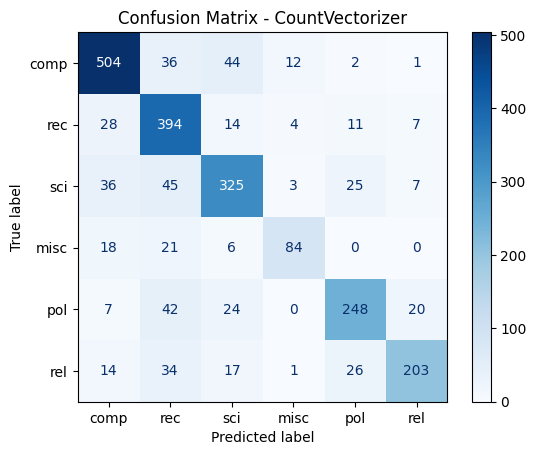

In [22]:
cm_cv = confusion_matrix(val_labels, pred_val_cv)
print("CountVectorizer Confusion Matrix:")
print(cm_cv)
print("\nCountVectorizer Classification Report:")
print(classification_report(val_labels, pred_val_cv))

disp_cv = ConfusionMatrixDisplay(confusion_matrix=cm_cv,
                                 display_labels=['comp', 'rec', 'sci', 'misc', 'pol', 'rel'])
disp_cv.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - CountVectorizer")
plt.show()

In [23]:
tfidf = TfidfVectorizer(vocabulary=voc)
X_train_tfidf = tfidf.fit_transform(train_texts_joined)
X_val_tfidf = tfidf.transform(val_texts_joined)

clf_tfidf = LogisticRegression(max_iter=1000)
clf_tfidf.fit(X_train_tfidf, train_labels_splt)

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:1368: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


LogisticRegression(max_iter=1000)

In [24]:
score_model_train = clf_tfidf.score(X_train_tfidf, train_labels_splt)
print("model score: {}".format(score_model_train))

score_model_test = clf_tfidf.score(X_val_tfidf, val_labels)
print("model score: {}".format(score_model_test))

model score: 0.9186830184509999
model score: 0.8015908086610694


TfidfVectorizer Confusion Matrix:
[[531  32  32   4   0   0]
 [ 25 402  19   2   7   3]
 [ 36  37 353   1  12   2]
 [ 29  21  12  67   0   0]
 [  6  42  26   0 255  12]
 [ 12  25  24   0  28 206]]

TfidfVectorizer Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       599
           1       0.72      0.88      0.79       458
           2       0.76      0.80      0.78       441
           3       0.91      0.52      0.66       129
           4       0.84      0.75      0.79       341
           5       0.92      0.70      0.80       295

    accuracy                           0.80      2263
   macro avg       0.83      0.76      0.78      2263
weighted avg       0.81      0.80      0.80      2263



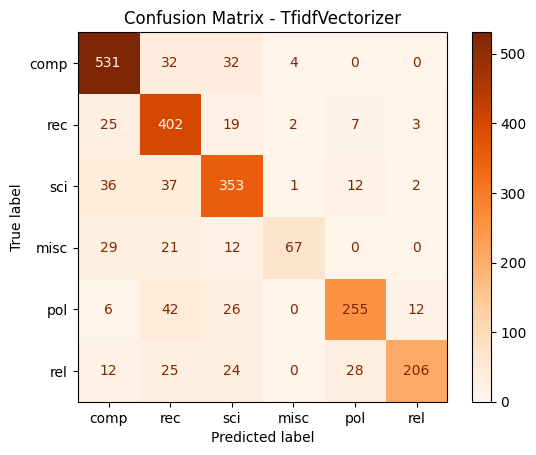

In [25]:
cm_tfidf = confusion_matrix(val_labels, clf_tfidf.predict(X_val_tfidf))
print("TfidfVectorizer Confusion Matrix:")
print(cm_tfidf)
print("\nTfidfVectorizer Classification Report:")
print(classification_report(val_labels, clf_tfidf.predict(X_val_tfidf)))

disp_tfidf = ConfusionMatrixDisplay(confusion_matrix=cm_tfidf,
                                    display_labels=['comp', 'rec', 'sci', 'misc', 'pol', 'rel'])
disp_tfidf.plot(cmap=plt.cm.Oranges)
plt.title("Confusion Matrix - TfidfVectorizer")
plt.show()

### I.4 - Dense Representations from Topic Modeling

Now, the goal is to re-use the bag-of-words representations we obtained earlier - but reduce their dimension through a **topic model**. Note that this allows to obtain reduced **document representations**, which we can again use directly to perform classification.
- Do this with two models: ```TruncatedSVD``` and ```LatentDirichletAllocation```
- Pick $300$ as the dimensionality of the latent representation (*i.e*, the number of topics)

<div class='alert alert-block alert-info'>
            Code:</div>

In [26]:
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation

In [27]:
svd = TruncatedSVD(n_components=300, random_state=42)
X_train_svd = svd.fit_transform(train_bow)
X_test_svd = svd.transform(val_bow)

clf_svd = LogisticRegression(max_iter=1000)
clf_svd.fit(X_train_svd, train_labels_splt)

LogisticRegression(max_iter=1000)

In [28]:
score_model_train = clf_svd.score(X_train_svd, train_labels_splt)
print("model score: {}".format(score_model_train))

score_model_test = clf_svd.score(X_test_svd, val_labels)
print("model score: {}".format(score_model_test))

model score: 0.7961551209811071
model score: 0.7485638532920902


Confusion Matrix for TruncatedSVD:
[[498  39  50   8   2   2]
 [ 26 399  17   3   6   7]
 [ 50  51 308   5  20   7]
 [ 18  21  11  78   0   1]
 [  9  48  31   0 225  28]
 [ 16  33  23   0  37 186]]

 LatentDirichletAllocation Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.83      0.82       599
           1       0.68      0.87      0.76       458
           2       0.70      0.70      0.70       441
           3       0.83      0.60      0.70       129
           4       0.78      0.66      0.71       341
           5       0.81      0.63      0.71       295

    accuracy                           0.75      2263
   macro avg       0.77      0.72      0.73      2263
weighted avg       0.76      0.75      0.75      2263



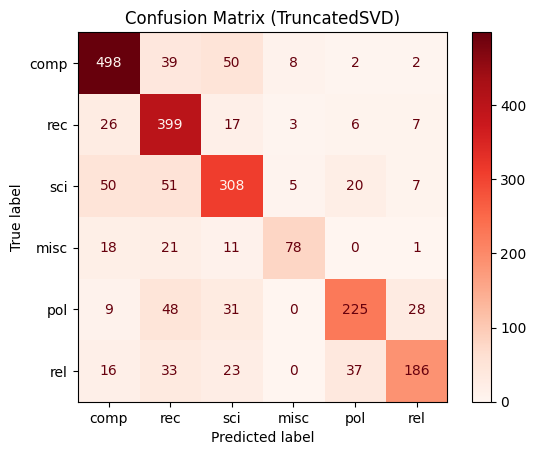

In [29]:
y_pred_svd = clf_svd.predict(X_test_svd)
cm_svd = confusion_matrix(val_labels, y_pred_svd)

print("Confusion Matrix for TruncatedSVD:")
print(cm_svd)
print("\n LatentDirichletAllocation Classification Report:")
print(classification_report(val_labels, clf_svd.predict(X_test_svd)))
disp_svd = ConfusionMatrixDisplay(confusion_matrix=cm_svd, display_labels=['comp', 'rec', 'sci', 'misc', 'pol', 'rel'])
disp_svd.plot(cmap=plt.cm.Reds)
plt.title("Confusion Matrix (TruncatedSVD)")
plt.show()

In [30]:
lda = LatentDirichletAllocation(n_components=300, random_state=42)
X_train_lda = lda.fit_transform(train_bow)
X_test_lda = lda.transform(val_bow)

clf_lda = LogisticRegression(max_iter=1000)
clf_lda.fit(X_train_lda, train_labels_splt)

LogisticRegression(max_iter=1000)

In [31]:
score_model_train = clf_lda.score(X_train_lda, train_labels_splt)
print("model score: {}".format(score_model_train))

score_model_test = clf_lda.score(X_test_lda, val_labels)
print("model score: {}".format(score_model_test))

model score: 0.6429123853717821
model score: 0.6756517896597437


Confusion Matrix for LatentDirichletAllocation:

 LatentDirichletAllocation Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.86      0.77       599
           1       0.66      0.71      0.69       458
           2       0.56      0.61      0.59       441
           3       0.84      0.20      0.33       129
           4       0.73      0.61      0.66       341
           5       0.75      0.62      0.68       295

    accuracy                           0.68      2263
   macro avg       0.71      0.60      0.62      2263
weighted avg       0.69      0.68      0.67      2263

[[515  11  60   1   3   9]
 [ 48 326  53   3  16  12]
 [ 83  52 271   1  23  11]
 [ 56  27  17  26   2   1]
 [  9  47  50   0 207  28]
 [ 21  30  29   0  31 184]]


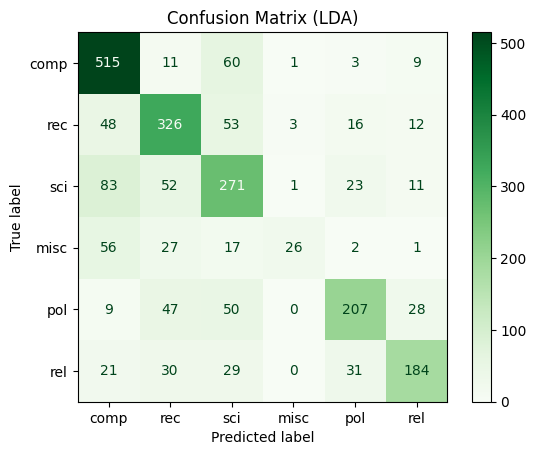

In [32]:
cm_lda = confusion_matrix(val_labels, clf_lda.predict(X_test_lda))
print("Confusion Matrix for LatentDirichletAllocation:")
print("\n LatentDirichletAllocation Classification Report:")
print(classification_report(val_labels, clf_lda.predict(X_test_lda)))
print(cm_lda)
disp_lda = ConfusionMatrixDisplay(confusion_matrix=cm_lda, display_labels=['comp', 'rec', 'sci', 'misc', 'pol', 'rel'])
disp_lda.plot(cmap=plt.cm.Greens)
plt.title("Confusion Matrix (LDA)")
plt.show()

### I.5 - Dense Count-based Representations

The following function allows to obtain very large-dimensional vectors for **words**. We will now follow a different procedure:
- Use ```TruncatedSVD```to obtain **word embeddings** of dimension $300$ from the output of the ```co_occurence_matrix```function, to which you can apply any intermediate transformation you see fit.
- Complete the following ```sentence_representations``` matrix, which will allow you to obtain **document representations** from **word embeddings**.
- Put the pipeline together and obtain document representations for both training and testing data, using word embeddings you got from the *training data co-occurence matrix*.
- Apply the same classification model as before, and display the results.

<div class='alert alert-block alert-info'>
            Code:</div>

In [121]:
def co_occurence_matrix(corpus, vocabulary, window=0, distance_weighting=False):
    """
    Params:
        corpus (list of list of strings): corpus of sentences
        vocabulary (dictionary): words to use in the matrix
        window (int): size of the context window; when 0, the context is the whole sentence
        distance_weighting (bool): indicates if we use a weight depending on the distance between words for co-oc counts
    Returns:
        matrix (array of size (len(vocabulary), len(vocabulary))): the co-oc matrix, using the same ordering as the vocabulary given in input
    """
    l = len(vocabulary)
    M = np.zeros((l,l))
    for sent in corpus:
        sent = [word for word in sent if word in vocabulary]
        # Obtain the indexes of the words in the sentence from the vocabulary
        sent_idx = [vocabulary[word] for word in sent]
        # Avoid one-word sentences - can create issues in normalization:
        if len(sent_idx) == 1:
                sent_idx.append(len(vocabulary)-1)
        # Go through the indexes and add 1 / dist(i,j) to M[i,j] if words of index i and j appear in the same window
        for i, idx in enumerate(sent_idx):
            # If we consider a limited context:
            if window > 0:
                # Create a list containing the indexes that are on the left of the current index 'idx_i'
                l_ctx_idx = sent_idx[max(0, i-window):i]
            # If the context is the entire document:
            else:
                # The list containing the left context is easier to create
                l_ctx_idx = sent_idx[:i]
            # Go through the list and update M[i,j]:
            for j, ctx_idx in enumerate(l_ctx_idx):
                if distance_weighting:
                    weight = 1.0 / (i-(max(0, i-window)+j))
                else:
                    weight = 1.0 / (i-j)
                M[idx, ctx_idx] += weight * 1.0
                M[ctx_idx, idx] += weight * 1.0
    return M

In [122]:
# Obtain the co-occurence matrix, transform it as needed, reduce its dimension
# Use TruncatedSVDto obtain word embeddings of dimension  300  from the output of the co_occurence_matrixfunction, to which you can apply any intermediate transformation you see fit.
M_mat = co_occurence_matrix(train_texts_splt, voc, window=5, distance_weighting=True)
svd_model = TruncatedSVD(n_components=300, random_state=42)
word_embeddings = svd_model.fit_transform(M_mat)

We will now use these representations for classification.
The basic model will be constructed in two steps:
- A function to obtain vector representations of criticism, from text, vocabulary, and vector representations of words. Such a function (to be completed below) will associate to each word of a review its embeddings, and create the representation for the whole sentence by summing these embeddings.
- A classifier will take these representations as input and make a prediction. To achieve this, we can first use logistic regression ```LogisticRegression``` from ```scikit-learn```

<div class='alert alert-block alert-info'>
            Code:</div>

In [35]:
print(M_mat.shape)
print(word_embeddings.shape)

(15001, 15001)
(15001, 300)


In [123]:
def sentence_representations(texts, vocabulary, embeddings, np_func=np.mean):
    """
    Represent the sentences as a combination of the vector of its words.
    Parameters
    ----------
    texts : a list of sentences
    vocabulary : dict
        From words to indexes of vector.
    embeddings : Matrix containing word representations
    np_func : function (default: np.sum)
        A numpy matrix operation that can be applied columnwise,
        like `np.mean`, `np.sum`, or `np.prod`.
    Returns
    -------
    np.array, dimension `(len(texts), embeddings.shape[1])`
    """
    representations = []
    for tokens in texts:
        vectors = []
        for word in tokens:
            if word in vocabulary and vocabulary[word] < embeddings.shape[0]:
                vectors.append(embeddings[vocabulary[word]])
        if not vectors:
            vectors = [np.zeros(embeddings.shape[1])]
        vectors = np_func(np.array(vectors), axis=0)
        representations.append(vectors)
    return representations

In [124]:
train_doc_reps = np.array(sentence_representations(train_texts_splt, voc, word_embeddings, np_func=np.sum))
val_doc_reps   = np.array(sentence_representations(val_texts, voc, word_embeddings, np_func=np.sum))

In [125]:
print(len(train_doc_reps))
print(len(val_doc_reps))

9051
2263


In [126]:
clf_dense = LogisticRegression(max_iter=10000, random_state=42)
clf_dense.fit(train_doc_reps, train_labels_splt)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=10000, random_state=42)

In [127]:
print("model accuracy in train: ", clf_dense.score(train_doc_reps, train_labels_splt))
print("model accuracy in val: ", clf_dense.score(val_doc_reps, val_labels))

model accuracy in train:  0.5098884101204287
model accuracy in val:  0.49094122845779936


In [128]:
cm_dense = confusion_matrix(val_labels, clf_dense.predict(val_doc_reps))
print("Dense Count-based Representations Confusion Matrix:")
print(cm_dense)
print("\nDense Count-based Representations Classification Report:")
print(classification_report(val_labels, clf_dense.predict(val_doc_reps)))

Dense Count-based Representations Confusion Matrix:
[[448  32  66  17  22  14]
 [107 199  36  18  49  49]
 [124  72 138   4  57  46]
 [ 46   5   7  67   2   2]
 [ 43  41  47   6 135  69]
 [ 49  38  27   4  53 124]]

Dense Count-based Representations Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.75      0.63       599
           1       0.51      0.43      0.47       458
           2       0.43      0.31      0.36       441
           3       0.58      0.52      0.55       129
           4       0.42      0.40      0.41       341
           5       0.41      0.42      0.41       295

    accuracy                           0.49      2263
   macro avg       0.48      0.47      0.47      2263
weighted avg       0.48      0.49      0.48      2263



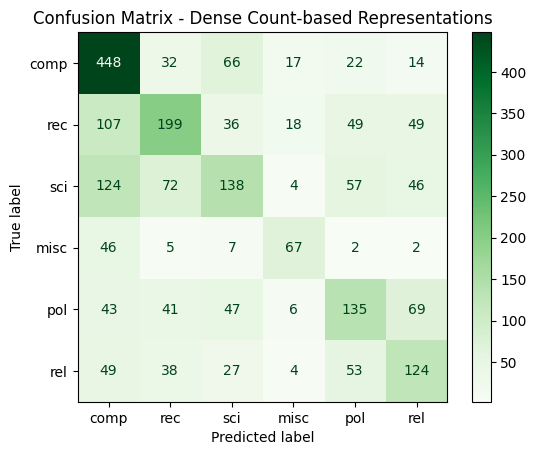

In [129]:
disp_dense = ConfusionMatrixDisplay(confusion_matrix=cm_dense,
                                    display_labels=['comp', 'rec', 'sci', 'misc', 'pol', 'rel'])
disp_dense.plot(cmap=plt.cm.Greens)
plt.title("Confusion Matrix - Dense Count-based Representations")
plt.show()

Comment: our dense count-based representation strangely seems to be underperforming significantly, with only ~51% train accuracy and ~48% validation accuracy.

### I.6 - Dense Prediction-based Representations

We will now use two types of word embeddings:
1. From ```Word2Vec```: which we will train ourselves
2. From ```GloVe```: which we will import

We will use the ```gensim``` library for its implementation of word2vec in python. Since we want to keep the same vocabulary as before: we'll first create the class, then get the vocabulary we generated above.

#### Glove

In [43]:
# we need to download some libraries
# !pip install gensim
# !pip install --force-reinstall numpy==1.24.4 scipy==1.10.1 gensim==4.3.2

In [44]:
import gensim.downloader as api
loaded_glove_model = api.load("glove-wiki-gigaword-300")

We can extract the embedding matrix this way, and check its size:

In [45]:
loaded_glove_embeddings = loaded_glove_model.vectors
print(loaded_glove_embeddings.shape)

(400000, 300)


We can see that there are $400,000$ words represented, and that the embeddings are of size $300$. We define a function that returns, from the loaded model, the vocabulary and the embedding matrix according to the structures we used before. We add, here again, an unknown word "UNK" in case there are words in our data that are not part of the $400,000$ words represented here.

In [46]:
def get_glove_voc_and_embeddings(glove_model):
    voc = {word : index for word, index in enumerate(glove_model.index_to_key)}
    voc['UNK'] = len(voc)
    embeddings = glove_model.vectors
    return voc, embeddings

In [47]:
loaded_glove_voc, loaded_glove_embeddings = get_glove_voc_and_embeddings(loaded_glove_model)

To be able to merge these $400.000$ words with those that are in our vocabulary, we can create a specific function that will extract the representations of the words that are in our vocabulary and return a matrix of the appropriate size:

In [48]:
def get_glove_adapted_embeddings(glove_model, input_voc):
    keys = {i: glove_model.key_to_index.get(w, None) for w, i in input_voc.items()}
    index_dict = {i: key for i, key in keys.items() if key is not None}
    embeddings = np.zeros((len(input_voc),glove_model.vectors.shape[1]))
    for i, ind in index_dict.items():
        embeddings[i] = glove_model.vectors[ind]
    return embeddings

This function takes as input the model loaded using the Gensim API, as well as a vocabulary we created ourselves, and returns the embedding matrix from the loaded model, for the words in our vocabulary and in the right order.


In [49]:
GloveEmbeddings = get_glove_adapted_embeddings(loaded_glove_model, voc) # Use your vocabulary

In [50]:
print(GloveEmbeddings.shape)

(15001, 300)


#### Word2Vec

We will use the ```gensim``` library for its implementation of word2vec in python. We'll have to make a specific use of it, since we want to keep the same vocabulary as before: we'll first create the class, then get the vocabulary we generated above.

In [51]:
from gensim.models import Word2Vec

model = Word2Vec(vector_size=300,
                 window=5,
                 null_word=len(voc), # Use word counts
                 epochs=30)
model.build_vocab_from_freq(counts) # Use word counts

The model takes as input a **list of list of words**: you need to tokenize the data beforehand.
In this case, you also need to indicate to the model the number of examples it should train with.
<div class='alert alert-block alert-info'>
            Code:</div>

In [52]:
ng_train_text_tokenized = []
ex = 0
for sent in train_texts_splt:
    tokenized_sent = [word for word in sent if word in voc]
    if tokenized_sent:
        ng_train_text_tokenized.append(tokenized_sent)
        ex += 1

In [53]:
print(len(ng_train_text_tokenized))
print(ex)

8799
8799


In [54]:
model.train(ng_train_text_tokenized, total_examples=ex, epochs=30, report_delay=1)

(32495713, 41386140)

In [55]:
W2VEmbeddings = model.wv.vectors
print(W2VEmbeddings.shape)

(15001, 300)


In [56]:
# Re-train a Logistic regression classifier with those representations
W2VDocReps_train = np.array(sentence_representations(train_texts_splt, voc, W2VEmbeddings, np_func=np.sum))
W2VDocReps_val   = np.array(sentence_representations(val_texts, voc, W2VEmbeddings, np_func=np.sum))
clf_w2v = LogisticRegression(max_iter=5000, random_state=42)
clf_w2v.fit(W2VDocReps_train, train_labels_splt)
pred_w2v = clf_w2v.predict(W2VDocReps_val)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [57]:
print("Model accuracy in train (W2V): ", clf_w2v.score(W2VDocReps_train, train_labels_splt))
print("Model accuracy in test (W2V): ", clf_w2v.score(W2VDocReps_val, val_labels))

Model accuracy in train (W2V):  0.7217986962766545
Model accuracy in test (W2V):  0.6456031816173221


Word2Vec Representations - Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.75      0.75       599
           1       0.57      0.75      0.65       458
           2       0.57      0.56      0.56       441
           3       0.64      0.61      0.63       129
           4       0.65      0.55      0.59       341
           5       0.71      0.54      0.62       295

    accuracy                           0.65      2263
   macro avg       0.65      0.63      0.63      2263
weighted avg       0.65      0.65      0.64      2263



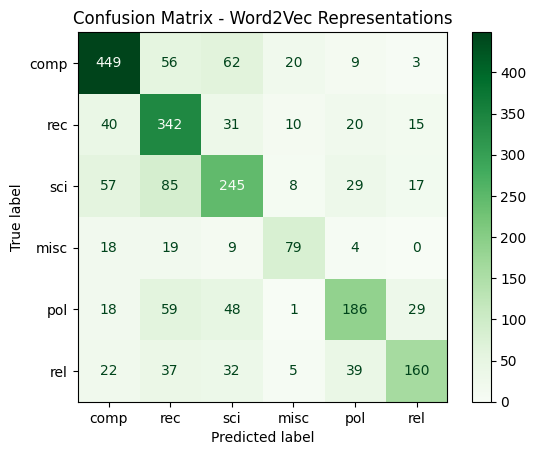

In [58]:
print("Word2Vec Representations - Classification Report:")
print(classification_report(val_labels, pred_w2v))

disp_w2v = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(val_labels, pred_w2v),
                                  display_labels=['comp', 'rec', 'sci', 'misc', 'pol', 'rel'])
disp_w2v.plot(cmap=plt.cm.Greens)
plt.title("Confusion Matrix - Word2Vec Representations")
plt.show()

In [59]:
GloveDocReps_train = np.array(sentence_representations(train_texts_splt, voc, GloveEmbeddings, np_func=np.sum))
GloveDocReps_val   = np.array(sentence_representations(val_texts, voc, GloveEmbeddings, np_func=np.sum))

In [60]:
clf_glove = LogisticRegression(max_iter=5000, random_state=42)
clf_glove.fit(GloveDocReps_train, train_labels_splt)
pred_glove = clf_glove.predict(GloveDocReps_val)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [61]:
print("Model accuracy in train (Glove): ", clf_glove.score(GloveDocReps_train, train_labels_splt))
print("Model accuracy in test (Glove): ", clf_glove.score(GloveDocReps_val, val_labels))

Model accuracy in train (Glove):  0.8409015578389128
Model accuracy in test (Glove):  0.754750331418471


GloVe Representations - Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.83      0.83       599
           1       0.72      0.85      0.78       458
           2       0.71      0.73      0.72       441
           3       0.71      0.58      0.64       129
           4       0.72      0.66      0.69       341
           5       0.80      0.67      0.73       295

    accuracy                           0.75      2263
   macro avg       0.75      0.72      0.73      2263
weighted avg       0.76      0.75      0.75      2263



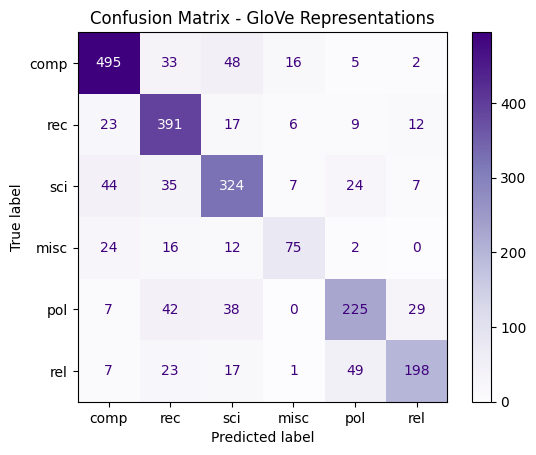

In [62]:
print("GloVe Representations - Classification Report:")
print(classification_report(val_labels, pred_glove))
disp_glove = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(val_labels, pred_glove),
                                    display_labels=['comp', 'rec', 'sci', 'misc', 'pol', 'rel'])
disp_glove.plot(cmap=plt.cm.Purples)
plt.title("Confusion Matrix - GloVe Representations")
plt.show()

<div class='alert alert-block alert-warning'>
            Question:</div>

- Why can we expect that the results obtained with embeddings extracted from representations pre-trained with Gl0ve are much better than word2vec ? What would be a 'fair' way to compare Gl0ve with word2vec ?

**Answer**:

As expected GloVe significantly outperforms Word2Vec in our classification task, achieving a test accuracy of 0.77 versus 0.65 for Word2Vec, along with higher precision, recall, and F1-scores across all classes. This performance difference can be attributed to several key factors:

- **Pre-training scale**: GloVe embeddings were trained on a large corpus of 6 billion tokens from Wikipedia and Gigaword. In contrast, the Word2Vec model used here was trained from scratch on our relatively small dataset of approximately 9,000 newsgroup texts.

- **Training method**: GloVe embeddings are based on global co-occurrence statistics, which tend to capture deeper semantic structure. Word2Vec, however, is trained using local context windows and optimizes embeddings to predict surrounding words, which is effective but more data-hungry.

A truly fair comparison between GloVe and Word2Vec would require controlling for the training data. Either:

- Use pre-trained versions of both (e.g., Word2Vec Google News 300 vs GloVe 300d), or  
- Train both models from scratch on the same dataset using identical vocabulary and hyperparameters.

<div class='alert alert-block alert-warning'>
            Question:</div>

- Try to have an high-level analysis of the results. Which representation works the best ? Did the confusion matrix give you any insight ?

**Answer**:

From both the classification reports and the confusion matrices, it is clear that **GloVe embeddings yield the most effective document representations** for this task.

#### Performance Highlights:

| Metric              | Word2Vec | GloVe  |
|---------------------|----------|--------|
| Test Accuracy       | 0.65     | 0.77   |
| Macro F1 Score      | 0.64     | 0.75   |
| Weighted F1 Score   | 0.65     | 0.76   |

GloVe excels particularly in the "rec" (recreational), "comp" (computing), and "sci" (science) categories, with F1 scores above 0.74 in each. Its high precision and recall show that it captures both relevant vocabulary and contextual meaning better than the Word2Vec model.

#### Confusion Matrix Insights:

- **GloVe**:
  - Achieves strong recall for class "rec" and "comp", showing it can correctly identify most documents in these categories.
  - Maintains good precision and balance across all six classes, including semantically close ones like "pol" (politics), "rel" (religion), and "sci".

- **Word2Vec**:
  - Performs reasonably for class "comp", but struggles a little more to distinguish between semantically overlapping classes such as "sci", "pol", and "rel".
  - This is likely due to the fact that embeddings were trained on a small corpus and thus lack the semantic separation that pre-trained GloVe vectors provide.

# II - Text classification with Pytorch

The goal of this second part of the lab is double: an introduction to using Pytorch for treating textual data, and implementing neural classification models that we can apply to our data - and then compare it to the models implemented previously.

In [63]:
import torch
import torch.nn as nn

### II.1 A (very small) introduction to pytorch

Pytorch Tensors are very similar to Numpy arrays, with the added benefit of being usable on GPU. For a short tutorial on various methods to create tensors of particular types, see [this link](https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html#sphx-glr-beginner-blitz-tensor-tutorial-py).
The important things to note are that Tensors can be created empty, from lists, and it is very easy to convert a numpy array into a pytorch tensor, and inversely.

In [64]:
a = torch.LongTensor(5)
b = torch.LongTensor([5])

print(a)
print(b)

tensor([134733124075537,       673016272,       673015616,               0,
            17179869186])
tensor([5])


In [65]:
a = torch.FloatTensor([2])
b = torch.FloatTensor([3])

print(a + b)

tensor([5.])


The main interest in us using Pytorch is the ```autograd``` package. ```torch.Tensor```objects have an attribute ```.requires_grad```; if set as True, it starts to track all operations on it. When you finish your computation, can call ```.backward()``` and all the gradients are computed automatically (and stored in the ```.grad``` attribute).

One way to easily cut a tensor from the computational once it is not needed anymore is to use ```.detach()```.
More info on automatic differentiation in pytorch on [this link](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#sphx-glr-beginner-blitz-autograd-tutorial-py).

In [66]:
x = torch.tensor(1., requires_grad=True)
w = torch.tensor(2., requires_grad=True)
b = torch.tensor(3., requires_grad=True)

# Build a computational graph.
y = w * x + b    # y = 2 * x + 3

# Compute gradients.
y.backward()

# Print out the gradients.
print(x.grad)    # x.grad = 2
print(w.grad)    # w.grad = 1
print(b.grad)    # b.grad = 1

tensor(2.)
tensor(1.)
tensor(1.)


In [67]:
x = torch.randn(10, 3)
y = torch.randn(10, 2)

# Build a fully connected layer.
linear = nn.Linear(3, 2)
for name, p in linear.named_parameters():
    print(name)
    print(p)

# Build loss function - Mean Square Error
criterion = nn.MSELoss()

# Forward pass.
pred = linear(x)

# Compute loss.
loss = criterion(pred, y)
print('Initial loss: ', loss.item())

# Backward pass.
loss.backward()

# Print out the gradients.
print ('dL/dw: ', linear.weight.grad)
print ('dL/db: ', linear.bias.grad)

weight
Parameter containing:
tensor([[ 0.1251, -0.2400, -0.3926],
        [-0.1034,  0.2140, -0.0760]], requires_grad=True)
bias
Parameter containing:
tensor([-0.1483, -0.5272], requires_grad=True)
Initial loss:  1.462330937385559
dL/dw:  tensor([[ 0.2159, -0.6037, -0.2235],
        [ 0.1134,  0.0774, -0.0784]])
dL/db:  tensor([-0.3314, -0.8432])


In [68]:
# You can perform gradient descent manually, with an in-place update ...
linear.weight.data.sub_(0.01 * linear.weight.grad.data)
linear.bias.data.sub_(0.01 * linear.bias.grad.data)

# Print out the loss after 1-step gradient descent.
pred = linear(x)
loss = criterion(pred, y)
print('Loss after one update: ', loss.item())

Loss after one update:  1.449341058731079


In [69]:
# Use the optim package to define an Optimizer that will update the weights of the model.
optimizer = torch.optim.SGD(linear.parameters(), lr=0.01)

# By default, gradients are accumulated in buffers( i.e, not overwritten) whenever .backward()
# is called. Before the backward pass, we need to use the optimizer object to zero all of the
# gradients.
optimizer.zero_grad()
loss.backward()

# Calling the step function on an Optimizer makes an update to its parameters
optimizer.step()

# Print out the loss after the second step of gradient descent.
pred = linear(x)
loss = criterion(pred, y)
print('Loss after two updates: ', loss.item())

Loss after two updates:  1.43666410446167


### II.2 Tools for data processing

```torch.utils.data.Dataset``` is an abstract class representing a dataset. Your custom dataset should inherit ```Dataset``` and override the following methods:
- ```__len__``` so that ```len(dataset)``` returns the size of the dataset.
- ```__getitem__``` to support the indexing such that ```dataset[i]``` can be used to get the i-th sample

Here is a toy example:

In [70]:
toy_corpus = ['I walked down down the boulevard',
              'I walked down the avenue',
              'I ran down the boulevard',
              'I walk down the city',
              'I walk down the the avenue']

toy_categories = [0, 0, 1, 0, 0]

In [71]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    # A pytorch dataset class for holding data for a text classification task.
    def __init__(self, data, categories):
        # Upon creating the Dataset object, store the data in an attribute
        # Split the text data and labels from each other
        self.X, self.Y = [], []
        for x, y in zip(data, categories):
            # We will propably need to preprocess the data - have it done in a separate method
            # We do it here because we might need corpus-wide info to do the preprocessing
            # For example, cutting all examples to the same length
            self.X.append(self.preprocess(x))
            self.Y.append(y)

    # Method allowing you to preprocess data
    def preprocess(self, text):
        text_pp = text.lower().strip()
        return text_pp

    # Overriding the method __len__ so that len(CustomDatasetName) returns the number of data samples
    def __len__(self):
        return len(self.Y)

    # Overriding the method __getitem__ so that CustomDatasetName[i] returns the i-th sample of the dataset
    def __getitem__(self, idx):
           return self.X[idx], self.Y[idx]

In [72]:
toy_dataset = CustomDataset(toy_corpus, toy_categories)

In [73]:
print(len(toy_dataset))
for i in range(len(toy_dataset)):
    print(toy_dataset[i])

5
('i walked down down the boulevard', 0)
('i walked down the avenue', 0)
('i ran down the boulevard', 1)
('i walk down the city', 0)
('i walk down the the avenue', 0)


```torch.utils.data.DataLoader``` is what we call an iterator, which provides very useful features:
- Batching the data
- Shuffling the data
- Load the data in parallel using multiprocessing workers.
and can be created very simply from a ```Dataset```. Continuing on our simple example:

In [74]:
toy_dataloader = DataLoader(toy_dataset, batch_size = 2, shuffle = True)

In [75]:
for e in range(3):
    print("Epoch:" + str(e))
    for x, y in toy_dataloader:
        print("Batch: " + str(x) + "; labels: " + str(y))

Epoch:0
Batch: ('i walk down the the avenue', 'i walk down the city'); labels: tensor([0, 0])
Batch: ('i walked down the avenue', 'i walked down down the boulevard'); labels: tensor([0, 0])
Batch: ('i ran down the boulevard',); labels: tensor([1])
Epoch:1
Batch: ('i walk down the city', 'i walked down down the boulevard'); labels: tensor([0, 0])
Batch: ('i walked down the avenue', 'i walk down the the avenue'); labels: tensor([0, 0])
Batch: ('i ran down the boulevard',); labels: tensor([1])
Epoch:2
Batch: ('i walked down down the boulevard', 'i ran down the boulevard'); labels: tensor([0, 1])
Batch: ('i walk down the city', 'i walked down the avenue'); labels: tensor([0, 0])
Batch: ('i walk down the the avenue',); labels: tensor([0])


#### Data processing of a text dataset

Now, we would like to apply what we saw to our case, and **create a specific class** ```TextClassificationDataset``` **inheriting** ```Dataset``` that will:
- Create a vocabulary from the data (same as above)
- Preprocess the data using this vocabulary, adding whatever we need for our pytorch model
- Have a ```__getitem__``` method that allows us to use the class with a ```Dataloader``` to easily build batches.

In [76]:
from torch.nn import functional as F
import random

from torch.nn.utils.rnn import pad_sequence

We will now need to create a ```TextClassificationDataset``` and a ```Dataloader``` for the training data, the validation data, and the testing data.

We will implement our ```TextClassificationDataset``` class, that we will build from:
- A list of documents: ```data```
- A list of the corresponding categories: ```categories```
We will add three optional arguments:
- First, a way to input a vocabulary (so that we can re-use the training vocabulary on the validation and training ```TextClassificationDataset```). By default, the value of the argument is ```None```.
- In order to work with batches, we will need to have sequences of the same size. That can be done via **padding** but we will still need to limit the size of documents (to avoid having batches of huge sequences that are mostly empty because of one very long documents) to a ```max_length```. Let's put it to 100 by default.
- Lastly, a ```min_freq``` that indicates how many times a word must appear to be taken in the vocabulary.

The idea behind **padding** is to transform a list of pytorch tensors (of maybe different length) into a two dimensional tensor - which we can see as a batch. The size of the first dimension is the one of the longest tensor - and other are **padded** with a chosen symbol: here, we choose 0.

**Careful: the symbol 0 is then reserved for padding. That means the vocabulary must begin at 1 !**

In [77]:
tensor_1 = torch.LongTensor([1, 4, 5])
tensor_2 = torch.LongTensor([2])
tensor_3 = torch.LongTensor([6, 7])

In [78]:
tensor_padded = pad_sequence([tensor_1, tensor_2, tensor_3], batch_first=True, padding_value = 0)
print(tensor_padded)

tensor([[1, 4, 5],
        [2, 0, 0],
        [6, 7, 0]])


<div class='alert alert-block alert-info'>
            Code:</div>

In [83]:
from collections import Counter
class TextClassificationDataset(Dataset):
    def __init__(self, data, categories, vocab = None, max_length = 200, voc_threshold = 10000):
        # Get all the data in a list
        self.data = data
        if isinstance(self.data[0], list):
            self.data = [" ".join(tokens) for tokens in self.data]
        # Set the maximum length we will keep for the sequences
        self.max_length = max_length
        # Allow to import a vocabulary (for valid/test datasets, that will use the training vocabulary)
        if vocab is not None:
            self.word2idx, self.idx2word = vocab
        else:
            # If no vocabulary imported, build it (and reverse)
            self.word2idx, self.idx2word = self.build_vocab(self.data, voc_threshold)

        # We then need to tokenize the data ..
        tokenized_data = [word_tokenize(clean(doc)) for doc in self.data]
        # Transform words into lists of indexes ... (use the .get() method to redirect unknown words to the UNK token)
        indexed_data = [[self.word2idx.get(word, self.word2idx["UNK"]) for word in doc] for doc in tokenized_data]
        # And transform this list of lists into a list of Pytorch LongTensors
        tensor_data = [torch.LongTensor(doc) for doc in indexed_data]
        # And the categories into a FloatTensor
        tensor_y = torch.FloatTensor(categories)
        # To finally cut it when it's above the maximum length
        cut_tensor_data = [doc[:max_length] for doc in tensor_data]

        # Now, we need to use the pad_sequence function to have the whole dataset represented as one tensor,
        # containing sequences of the same length. We choose the padding_value to be 0, the we want the
        # batch dimension to be the first dimension
        self.tensor_data = pad_sequence(cut_tensor_data, batch_first=True, padding_value=self.word2idx.get("PAD", 0))
        self.tensor_y = tensor_y

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # The iterator just gets one particular example with its category
        # The dataloader will take care of the shuffling and batching
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return self.tensor_data[idx], self.tensor_y[idx]

    def build_vocab(self, corpus, voc_threshold):
        """
        Same as in the previously: we want to output word_index, a dictionary containing words
        and their corresponding indexes as {word : indexes}
        But we also want the reverse, which is a dictionary {indexes: word}
        """
        # To complete
        # Careful, here we need to shift the indexes by 1 to put the padding symbol to 0
        tokenized = [word_tokenize(clean(doc)) for doc in corpus]
        word_freq = Counter(word for sent in tokenized for word in sent)
        most_common = word_freq.most_common(voc_threshold)
        word2idx = {word: idx + 1 for idx, (word, _) in enumerate(most_common)}
        word2idx["UNK"] = len(word2idx) + 1
        idx2word = {idx: word for word, idx in word2idx.items()}
        return word2idx, idx2word

    def get_vocab(self):
        # A simple way to get the training vocab when building the valid/test
        return self.word2idx, self.idx2word

In [86]:
training_dataset = TextClassificationDataset(train_texts_splt, train_labels_splt)
training_word2idx, training_idx2word = training_dataset.get_vocab()

In [87]:
valid_dataset = TextClassificationDataset(val_texts, val_labels, (training_word2idx, training_idx2word))
test_dataset = TextClassificationDataset(ng_test_text, ng_test_labels, (training_word2idx, training_idx2word))

In [88]:
training_dataloader = DataLoader(training_dataset, batch_size = 200, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size = 25)
test_dataloader = DataLoader(test_dataset, batch_size = 25)

In [89]:
print(valid_dataset[1])

(tensor([   59,    86,     7,  2030,    57,   189,    31,   396,   893,     1,
         1261,  1180,    59,    86,     7,    57,   396,   125,   413,    69,
         1180,    59,    86,     7,    57,    29,     1,  2517,  7325,   396,
         2169,    49, 10001,    41,    52,  2227,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,

In [90]:
example_batch = next(iter(training_dataloader))
print(example_batch[0].size())
print(example_batch[1].size())

torch.Size([200, 200])
torch.Size([200])


### II.3 A simple averaging model

Now, we will implement in Pytorch what we did in the previous TP: a simple averaging model. For each model we will implement, we need to create a class which inherits from ```nn.Module``` and redifine the ```__init__``` method as well as the ```forward``` method.

In [91]:
import torch.optim as optim

<div class='alert alert-block alert-info'>
            Code:</div>

In [92]:
class AveragingModel(nn.Module):

    def __init__(self, embedding_dim, vocabulary_size, categories_num):
        super().__init__()
        # Create an embedding object. Be careful to padding - you need to increase the vocabulary size by one !
        # Look into the arguments of the nn.Embedding class
        self.embeddings = nn.Embedding(vocabulary_size + 1, embedding_dim, padding_idx=0)
        # Create a linear layer that will transform the mean of the embeddings into classification scores
        self.linear = nn.Linear(embedding_dim, categories_num)

    def forward(self, inputs):
        # Remember: the inputs are written as Batch_size * seq_length * embedding_dim
        # First, take the mean of the embeddings of the document
        embedded = self.embeddings(inputs)
        x = embedded.mean(dim=1)
        o = self.linear(x)
        return o

In [93]:
model = AveragingModel(300, len(training_word2idx), max(ng_train_labels)+1)
# Create an optimizer
opt = optim.Adam(model.parameters(), lr=0.0025, betas=(0.9, 0.999))
# The criterion is a cross entropy loss based on logits,
# meaning that the softmax is integrated into the criterion
criterion = nn.CrossEntropyLoss()

<div class='alert alert-block alert-info'>
            Code:</div>

In [94]:
# Implement a training function, which will train the model with the corresponding optimizer and criterion,
# with the appropriate dataloader, for one epoch.

def train_epoch(model, opt, criterion, dataloader):
    model.train()
    losses = []
    for i, (x, y) in enumerate(dataloader):
        opt.zero_grad()
        # (1) Forward
        pred = model(x)
        # (2) Compute diff
        loss = criterion(pred, y.long())
        # (3) Compute gradients
        loss.backward()
        # (4) update weights
        opt.step()
        losses.append(loss.item())
        # Count the number of correct predictions in the batch - here, you'll need to use the softmax
        num_corrects = (torch.argmax(pred, dim=1) == y.long()).sum().item()
        acc = 100.0 * num_corrects/len(y)

        if (i%20 == 0):
            print("Batch " + str(i) + " : training loss = " + str(loss.item()) + "; training acc = " + str(acc))
    return losses

<div class='alert alert-block alert-info'>
            Code:</div>

In [95]:
# Same for the evaluation ! We don't need the optimizer here.

def eval_model(model, criterion, evalloader):
    model.eval()
    total_epoch_loss = 0
    total_epoch_acc = 0
    with torch.no_grad():
        for i, (x, y) in enumerate(evalloader):
            pred = model(x)
            loss = criterion(pred, y.long())
            num_corrects = (torch.argmax(pred, dim=1) == y.long()).sum().item()
            acc = 100.0 * num_corrects/len(y)
            total_epoch_loss += loss.item()
            total_epoch_acc += acc

    return total_epoch_loss/(i+1), total_epoch_acc/(i+1)

In [96]:
# A function which will help you execute experiments rapidly - with a early_stopping option when necessary.

def experiment(model, opt, criterion, num_epochs = 10, early_stopping = True):
    train_losses = []
    if early_stopping:
        best_valid_loss = 10.
    print("Beginning training...")
    for e in range(num_epochs):
        print("Epoch " + str(e+1) + ":")
        train_losses += train_epoch(model, opt, criterion, training_dataloader)
        valid_loss, valid_acc = eval_model(model, criterion, valid_dataloader)
        print("Epoch " + str(e+1) + " : Validation loss = " + str(valid_loss) + "; Validation acc = " + str(valid_acc))
        if early_stopping:
            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
            else:
                print("Early stopping.")
                break
    test_loss, test_acc = eval_model(model, criterion, test_dataloader)
    print("Epoch " + str(e+1) + " : Test loss = " + str(test_loss) + "; Test acc = " + str(test_acc))
    return train_losses

In [97]:
train_losses = experiment(model, opt, criterion)

Beginning training...
Epoch 1:
Batch 0 : training loss = 1.8006410598754883; training acc = 9.5
Batch 20 : training loss = 1.704264521598816; training acc = 27.5
Batch 40 : training loss = 1.6227335929870605; training acc = 50.5
Epoch 1 : Validation loss = 1.6080497830778688; Validation acc = 48.99070160608622
Epoch 2:
Batch 0 : training loss = 1.6011216640472412; training acc = 58.5
Batch 20 : training loss = 1.4894781112670898; training acc = 57.5
Batch 40 : training loss = 1.3934128284454346; training acc = 59.5
Epoch 2 : Validation loss = 1.3723060049853482; Validation acc = 60.63905325443787
Epoch 3:
Batch 0 : training loss = 1.3490533828735352; training acc = 61.0
Batch 20 : training loss = 1.2343225479125977; training acc = 67.5
Batch 40 : training loss = 1.0658646821975708; training acc = 72.5
Epoch 3 : Validation loss = 1.1335345454268404; Validation acc = 66.7861369399831
Epoch 4:
Batch 0 : training loss = 1.091050624847412; training acc = 72.5
Batch 20 : training loss = 0.99

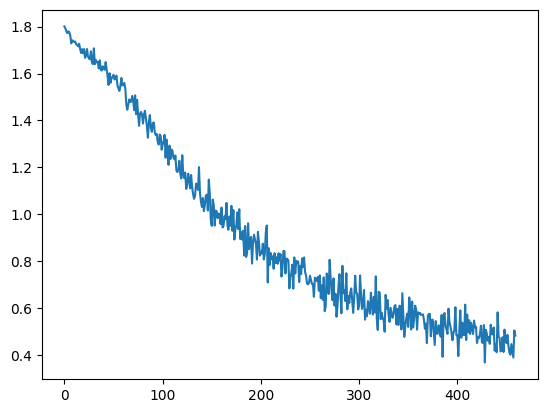

In [98]:
import matplotlib.pyplot as plt
plt.plot(train_losses)

### II.4 Initializing with pre-trained embeddings:

Now, we would like to integrate pre-trained word embeddings into our model ! However, we need to not forget to add a vector for the padding symbol.

In [99]:
def get_glove_adapted_embeddings(glove_model, input_voc):
    keys = {i: glove_model.key_to_index.get(w, None) for w, i in input_voc.items()}
    index_dict = {i: key for i, key in keys.items() if key is not None}
    # Important change here: add one supplementary word for padding
    embeddings = np.zeros((len(input_voc)+1,glove_model.vectors.shape[1]))
    for i, ind in index_dict.items():
        embeddings[i] = glove_model.vectors[ind]
    return embeddings

GloveEmbeddings = get_glove_adapted_embeddings(loaded_glove_model, training_word2idx)

In [100]:
print(GloveEmbeddings.shape)

(10002, 300)


Here, implement a ```PretrainedAveragingModel``` very similar to the previous model, using the ```nn.Embedding``` method ```from_pretrained()``` to initialize the embeddings from a numpy array. Use the ```requires_grad_``` method to specify if the model must fine-tune the embeddings or not !
<div class='alert alert-block alert-info'>
            Code:</div>

In [101]:
class PretrainedAveragingModel(nn.Module):
    # To complete !
    def __init__(self, embedding_dim, num_classes, pretrained_embeddings, grad_requires = False):
        super().__init__()

        self.embeddings = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=grad_requires)
        self.linear = nn.Linear(embedding_dim, num_classes)

    def forward(self, inputs):
        x = torch.mean(self.embeddings(inputs), dim=1)
        o = self.linear(x)
        return o

<div class='alert alert-block alert-warning'>
            Questions:</div>
            
- What are the results **with and without fine-tuning of embeddings imported from GloVe** ? Explain them.
- Look again at the confusion matrix these results in more details.

In [102]:
model_pre_trained = PretrainedAveragingModel(300, max(ng_train_labels)+1, torch.FloatTensor(GloveEmbeddings), True)
opt_pre_trained = optim.Adam(model_pre_trained.parameters(), lr=0.0025, betas=(0.9, 0.999))

In [103]:
train_losses = experiment(model_pre_trained, opt_pre_trained, criterion)

Beginning training...
Epoch 1:
Batch 0 : training loss = 1.8164421319961548; training acc = 5.0
Batch 20 : training loss = 1.6895508766174316; training acc = 43.0
Batch 40 : training loss = 1.5970553159713745; training acc = 48.5
Epoch 1 : Validation loss = 1.5911588629523477; Validation acc = 52.730346576500416
Epoch 2:
Batch 0 : training loss = 1.5866016149520874; training acc = 52.0
Batch 20 : training loss = 1.520816683769226; training acc = 56.5
Batch 40 : training loss = 1.4839898347854614; training acc = 59.5
Epoch 2 : Validation loss = 1.4761282454480182; Validation acc = 57.25781910397295
Epoch 3:
Batch 0 : training loss = 1.459022879600525; training acc = 62.0
Batch 20 : training loss = 1.4004273414611816; training acc = 67.5
Batch 40 : training loss = 1.4167380332946777; training acc = 56.5
Epoch 3 : Validation loss = 1.3894181369425176; Validation acc = 58.62045646661031
Epoch 4:
Batch 0 : training loss = 1.3565579652786255; training acc = 63.0
Batch 20 : training loss = 1.

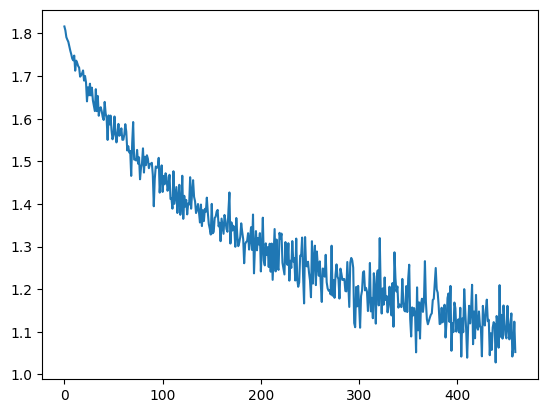

In [104]:
plt.plot(train_losses)

In [105]:
model_pre_trained_light = PretrainedAveragingModel(300, max(ng_train_labels)+1, torch.FloatTensor(GloveEmbeddings), False)
opt_pre_trained_light = optim.Adam(model_pre_trained_light.parameters(), lr=0.0025, betas=(0.9, 0.999))

In [106]:
train_losses = experiment(model_pre_trained_light, opt_pre_trained_light, criterion)

Beginning training...
Epoch 1:
Batch 0 : training loss = 1.796270489692688; training acc = 11.0
Batch 20 : training loss = 1.635953426361084; training acc = 30.5
Batch 40 : training loss = 1.4818042516708374; training acc = 48.0
Epoch 1 : Validation loss = 1.4837995282896272; Validation acc = 48.38207945900253
Epoch 2:
Batch 0 : training loss = 1.4035499095916748; training acc = 54.0
Batch 20 : training loss = 1.4039117097854614; training acc = 51.5
Batch 40 : training loss = 1.1973958015441895; training acc = 63.0
Epoch 2 : Validation loss = 1.2166696917879714; Validation acc = 62.130177514792905
Epoch 3:
Batch 0 : training loss = 1.1771142482757568; training acc = 67.0
Batch 20 : training loss = 1.1194634437561035; training acc = 62.5
Batch 40 : training loss = 1.0719125270843506; training acc = 67.5
Epoch 3 : Validation loss = 1.0104772743287977; Validation acc = 68.67962806424346
Epoch 4:
Batch 0 : training loss = 0.8925748467445374; training acc = 79.0
Batch 20 : training loss = 0

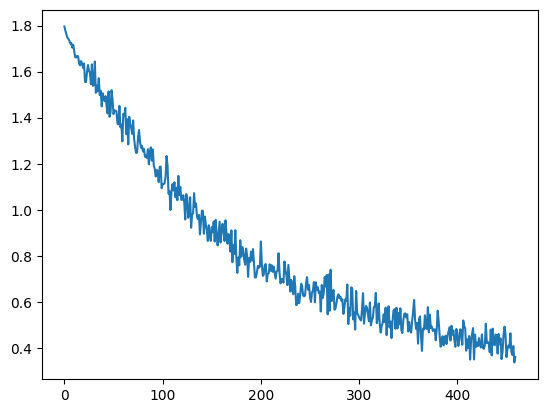

In [107]:
plt.plot(train_losses)

**Answer 1**:

After testing the two models using GloVe pre-trained embeddings: one with frozen embeddings and one with fine-tuning enabled. Surprisingly, the frozen embedding model achieved significantly better performance — reaching 80.4% validation accuracy and 77.9% test accuracy, compared to only 63.4% / 63.5% with fine-tuning.

This result suggests that fine-tuning embeddings on small datasets may degrade performance, as it can destroy general semantic relationships encoded in the original GloVe vectors. In contrast, keeping embeddings frozen preserves these properties and allows the model to focus on learning the classification task with more stable features.

Classification Report:
              precision    recall  f1-score   support

        comp     0.8470    0.8353    0.8411      1955
         rec     0.6819    0.9031    0.7771      1590
         sci     0.7642    0.7080    0.7350      1579
        misc     0.8683    0.6256    0.7273       390
         pol     0.8042    0.7276    0.7640      1050
         rel     0.8470    0.7035    0.7686       968

    accuracy                         0.7801      7532
   macro avg     0.8021    0.7505    0.7688      7532
weighted avg     0.7899    0.7801    0.7794      7532



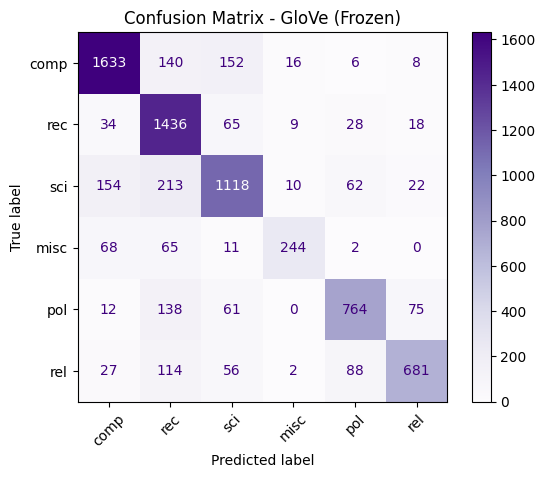

In [108]:
model = model_pre_trained_light
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for x_batch, y_batch in test_dataloader:
        x_batch = x_batch.long()
        y_batch = y_batch.long()
        outputs = model(x_batch)
        predictions = torch.argmax(outputs, dim=1)
        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
report = classification_report(all_labels, all_preds, target_names=['comp', 'rec', 'sci', 'misc', 'pol', 'rel'], digits=4)
print("Classification Report:")
print(report)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['comp', 'rec', 'sci', 'misc', 'pol', 'rel'])
disp.plot(cmap="Purples", xticks_rotation=45)
plt.title("Confusion Matrix - GloVe (Frozen)")
plt.grid(False)
plt.show()

Classification Report:
              precision    recall  f1-score   support

        comp     0.5529    0.8926    0.6828      1955
         rec     0.6334    0.7629    0.6922      1590
         sci     0.6617    0.4807    0.5569      1579
        misc     0.7556    0.0872    0.1563       390
         pol     0.7988    0.4952    0.6114      1050
         rel     0.8252    0.5269    0.6431       968

    accuracy                         0.6348      7532
   macro avg     0.7046    0.5409    0.5571      7532
weighted avg     0.6725    0.6348    0.6161      7532



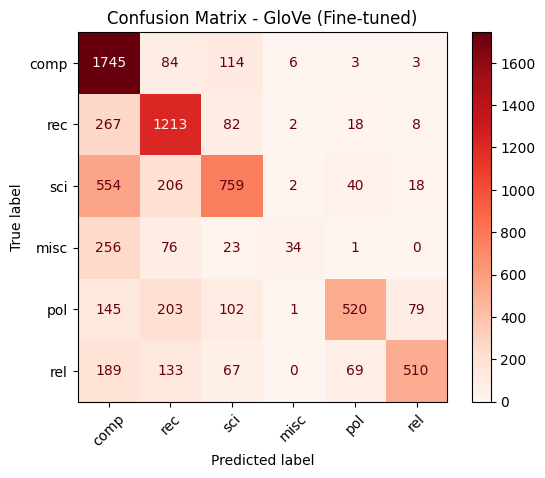

In [109]:
model = model_pre_trained
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for x_batch, y_batch in test_dataloader:
        x_batch = x_batch.long()
        y_batch = y_batch.long()
        outputs = model(x_batch)
        predictions = torch.argmax(outputs, dim=1)
        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
report = classification_report(all_labels, all_preds, target_names=['comp', 'rec', 'sci', 'misc', 'pol', 'rel'], digits=4)
print("Classification Report:")
print(report)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['comp', 'rec', 'sci', 'misc', 'pol', 'rel'])
disp.plot(cmap="Reds", xticks_rotation=45)
plt.title("Confusion Matrix - GloVe (Fine-tuned)")
plt.grid(False)
plt.show()

**Answer 2**:

By examining the confusion matrices and classification reports, we observe that the frozen GloVe model produces more reliable predictions across all categories. It especially improves classification of semantically close categories such as sci, rel, and pol. The fine-tuned version, in contrast, tends to confuse these groups, likely due to degraded semantic relationships caused by updates to the embeddings.

The confusion matrix of the frozen model shows that the category sci suffers from low recall (≃48%), meaning that more than half of the documents that belong to this category are misclassified. Most of them are incorrectly predicted as comp or rec, which makes sense since these categories are semantically related. The model also shows moderate precision (≃66%) for sci, suggesting that when it does predict sci, it is reasonably confident, but it misses many actual sci documents.